# Small n Evaluations: What to do with a p-value of .23?

- you've run the evaluation and you get your estimate and the p-value is .23
- this is better than a p-value of .5, but what does it really tell you?
- or, more to the point, what should we tell the client?

The client may reasonably want to know what the probability that there is some positive effect?
The client may also have access to an alternate intervention that has an effect size of .1 and costs about the same amount of money as this intervention.  In that case, the client may want to know what the probability that the effect is at least .1.

In [6]:
# generate data for treatment and control
import numpy as np
import scipy.stats as stats

np.random.seed(8675209)
control_mean = .6
effect_size = .15
size_t = 40
size_c = 30

# generate some data and do a test of equality.  repeat until i get a p-value that i like
dummy = True
while dummy == True:
    control = np.random.binomial(1,control_mean,size_c)
    treatment = np.random.binomial(1,control_mean+effect_size, size_t)

    # estimate the p-value for a t-test
    result = stats.ttest_ind_from_stats(treatment.mean(),treatment.std(), size_t, control.mean(),control.std(), size_c) 
    if result[1] > .2 and result[1] < .25:
        dummy = False
        
print(control.mean(),treatment.mean())

0.533333333333 0.675


In [7]:
# combine data into a single vector and add an array for treatment status
treat_status = np.repeat(np.array([0,1]), [size_c, size_t])
outcome = np.concatenate((control, treatment),0)

In [11]:
treat_status

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [10]:
# estimate this model using a logit.  We already have the p-value from a simple t-test but 
# it's useful to compare the frequentist logit estimates to the Bayesian logit estimates we get later
import statsmodels.api as sm
X = sm.add_constant(treat_status)
model = sm.GLM(outcome, X, family = sm.families.Binomial())
print(model.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   70
Model:                            GLM   Df Residuals:                       68
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -45.951
Date:                Sun, 31 Jul 2016   Deviance:                       91.902
Time:                        10:01:44   Pearson chi2:                     70.0
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1335      0.366      0.365      0.715        -0.584     0.851
x1             0.5974      0.498      1.200      0.2

*Note that the p-value of the treatment variable is .23 as we expected*

In [180]:
# estimate the data using a model
# import the pystan package.  this package allows python to call the Stan language
import pystan
# The next few lines define the model in Stan.  The entire Stan model is saved as the python variable
# stan_code which I use later to fit the model. 
stan_code = '''
data {
    int<lower=0> N;  // number of observations
    int<lower=0,upper=1> y[N];  // outcome data
    vector[N] treat;  // variable indicating treatment arm for each observation
}
parameters {
    real alpha;
    real beta;
}
model {
    alpha ~ normal(0,10);  // this translate to a prior that the control mean is .5 
    beta ~ normal(0,10); // 
    y ~ bernoulli_logit(alpha + beta*treat);
}    
generated quantities {
    real effect;
    effect <- inv_logit(alpha+beta)-inv_logit(alpha);
}

'''
stan_data = {'N': len(outcome),
        'y': outcome,
        'treat': treat_status }

In [181]:
fit = pystan.stan(model_code=stan_code, data=stan_data, iter=1000, chains=4)

/Users/douglasjohnson/anaconda/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/douglasjohnson/anaconda/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/douglasjohnson/anaconda/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/douglasjohnson/anaconda/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pic

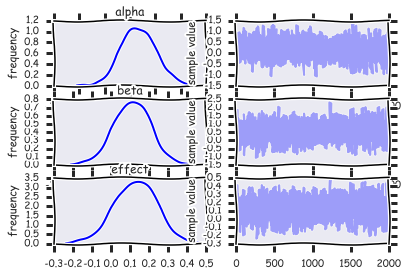

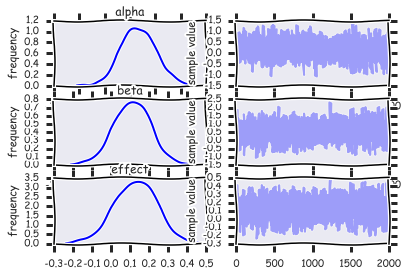

In [190]:
fit.traceplot()

In [182]:
print(fit)

Inference for Stan model: anon_model_36ba8eeb34357632d8ec438c7bd702ef.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    0.17  8.4e-3   0.37  -0.56  -0.07   0.16   0.42   0.92   2000   1.01
beta     0.56    0.01   0.51  -0.46   0.21   0.57   0.91   1.56   2000   1.01
effect   0.13  2.6e-3   0.12  -0.11   0.05   0.13   0.21   0.36   2000   1.01
lp__   -46.98    0.02   1.03 -49.84 -47.32 -46.66 -46.24 -45.98   2000    1.0

Samples were drawn using NUTS(diag_e) at Sat Jul 30 21:21:31 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


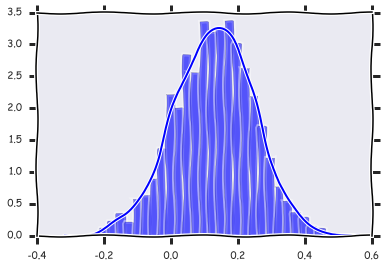

In [183]:
# look at the % of time the effect is greater than 0
% matplotlib inline
import matplotlib.pyplot as plt
plt.xkcd()
import seaborn as sns

effect_sim = fit.extract()['effect']
sns.distplot(effect_sim)

In [184]:
# calculate the probability that effect size is greater than 0
(effect_sim >0).sum()/len(effect_sim)

0.86050000000000004

Wow! That's actually pretty good. Though our p-value was greater than .1 the probability that the effect size is greater than 0 is actually quite high at 86%! Let's see what the probability that the effect size is greater than other values.

In [187]:
for i in np.linspace(0,.1,11):
    print("Probability effect size less than ",i, "is ", (effect_sim >i).sum()/len(effect_sim))

Probability effect size less than  0.0 is  0.8605
Probability effect size less than  0.01 is  0.841
Probability effect size less than  0.02 is  0.823
Probability effect size less than  0.03 is  0.8005
Probability effect size less than  0.04 is  0.7725
Probability effect size less than  0.05 is  0.745
Probability effect size less than  0.06 is  0.718
Probability effect size less than  0.07 is  0.695
Probability effect size less than  0.08 is  0.665
Probability effect size less than  0.09 is  0.641
Probability effect size less than  0.1 is  0.6045


In [188]:
temp_range = np.linspace(10,90,9)
for i,j in zip(temp_range, np.percentile(effect_sim,temp_range)):
    print(i, "th percentile is: ",j, sep ="")

10.0th percentile is: -0.0167680629696
20.0th percentile is: 0.0305826687543
30.0th percentile is: 0.068083555607
40.0th percentile is: 0.101441978647
50.0th percentile is: 0.13249100305
60.0th percentile is: 0.163411969463
70.0th percentile is: 0.194463193555
80.0th percentile is: 0.228169721675
90.0th percentile is: 0.272408038948


# Converting standard errors to 
You may be wondering, is there a way to just use the standard error to figure out what the probability that the effect size is greater than X is? The short answer is that "no, not really." There 